Author: Zhile Xu

UUN: s2500393

In [1]:
import os
import glob
import spacy
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

# set up the environment
pyLDAvis.enable_notebook()
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# load spacy model
nlp = spacy.load("en_core_web_lg")

In [3]:
# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

In [4]:
# load training data
train_data, train_labels, train_files = load_data('data/train')

## Preprocess the Data

In [5]:
# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
docs = preprocess_texts(train_data)


In [6]:
# function to remove stopwords and punctuation
def remove_stopwords_punctuation(doc):
    # remove stopwords and punctuation
    doc = [token for token in doc if not token.is_stop and not token.is_punct]
    # remove "\n", "Mr", "Mrs", "Miss" and "Ms"
    doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
    # remove single characters
    doc = [token for token in doc if len(token.text) > 1]
    return doc

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# remove stopwords and punctuation
cleaned_docs = [remove_stopwords_punctuation(doc) for doc in docs]
# lowercase and lemmatise the tokens
lemmatised_docs = lowercase_and_lemmatise(cleaned_docs)

## Topic Modelling

In [7]:
# function to build a topic model (LDA)
def build_topic_model(docs, dictionary, corpus, num_topics):

    # train an LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, iterations=50,
                          num_topics=num_topics, passes=20, random_state=123)

    # compute the coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=docs, 
                                     dictionary=dictionary, coherence='c_v')

    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_model.get_coherence()}')

    return lda_model, coherence_model.get_coherence()


In [8]:
print("Topic model for the whole dataset")

# create a dictionary
dictionary = Dictionary(lemmatised_docs)

# filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in lemmatised_docs]

coherence = pd.DataFrame(index=range(2, 21), columns=['coherence'])
for num_topics in coherence.index:
    _, coherence_score = build_topic_model(lemmatised_docs, dictionary, corpus, num_topics)
    coherence.loc[num_topics, 'coherence'] = coherence_score

Topic model for the whole dataset
Num Topics: 2, Coherence Score: 0.33635494730378634
Num Topics: 3, Coherence Score: 0.3860820429383778
Num Topics: 4, Coherence Score: 0.3954857323103964
Num Topics: 5, Coherence Score: 0.4019111325848919
Num Topics: 6, Coherence Score: 0.4314718497095691
Num Topics: 7, Coherence Score: 0.4218464975953072
Num Topics: 8, Coherence Score: 0.40239450717573866
Num Topics: 9, Coherence Score: 0.3611277731036517
Num Topics: 10, Coherence Score: 0.3930427384422649
Num Topics: 11, Coherence Score: 0.426232538594101
Num Topics: 12, Coherence Score: 0.4140460320058364
Num Topics: 13, Coherence Score: 0.43606071396071105
Num Topics: 14, Coherence Score: 0.46817710337303053
Num Topics: 15, Coherence Score: 0.4334099632589433
Num Topics: 16, Coherence Score: 0.4627202624261915
Num Topics: 17, Coherence Score: 0.4404309181083443
Num Topics: 18, Coherence Score: 0.4250927857847577
Num Topics: 19, Coherence Score: 0.4341514525628968
Num Topics: 20, Coherence Score: 0.

In [9]:
# find the optimal number of topics
optimal_num_topics = coherence['coherence'].idxmax()
print(f'The optimal number of topics is: {optimal_num_topics}')

The optimal number of topics is: 14


In [10]:
# train the LDA model with the optimal number of topics
lda_model, _ = build_topic_model(lemmatised_docs, dictionary, corpus, optimal_num_topics)

Num Topics: 14, Coherence Score: 0.46817710337303053


In [11]:
# print the words in each topic
for topic_id in range(optimal_num_topics):
    # get the words in the topic
    print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

Topic 0: 0.074*"axa" + 0.046*"admiral" + 0.027*"lv" + 0.019*"vehicle" + 0.017*"repair" + 0.010*"loss" + 0.009*"report" + 0.007*"accident" + 0.007*"liability" + 0.006*"haven"
Topic 1: 0.034*"repair" + 0.032*"phone" + 0.026*"aa" + 0.017*"d&g" + 0.015*"hdi" + 0.012*"item" + 0.009*"fridge" + 0.009*"part" + 0.009*"warranty" + 0.008*"decline"
Topic 2: 0.040*"accredited" + 0.038*"rsa" + 0.030*"repair" + 0.025*"work" + 0.017*"property" + 0.010*"settlement" + 0.009*"carry" + 0.008*"report" + 0.007*"contractor" + 0.007*"garage"
Topic 3: 0.022*"work" + 0.015*"contractor" + 0.014*"repair" + 0.014*"delay" + 0.012*"property" + 0.011*"loss" + 0.010*"aviva" + 0.009*"2022" + 0.007*"settlement" + 0.007*"accommodation"
Topic 4: 0.023*"zurich" + 0.020*"ageas" + 0.016*"travel" + 0.014*"vehicle" + 0.013*"delay" + 0.011*"garage" + 0.011*"car" + 0.011*"aviva" + 0.011*"trip" + 0.011*"day"
Topic 5: 0.054*"car" + 0.052*"advantage" + 0.016*"vehicle" + 0.010*"driver" + 0.009*"haven" + 0.009*"central" + 0.009*"comp

In [17]:
# print 5 document text with their topics
for i in range(5):
    # choose a random document
    doc_id = random.randint(0, len(lemmatised_docs))
    # get the document's topic distribution
    topic_distribution = lda_model.get_document_topics(corpus[doc_id])
    # get the topic with the highest probability
    topic_id = max(topic_distribution, key=lambda x: x[1])[0]
    # print the document text and the topic
    print(f'File: {train_files[doc_id]}')
    print(f'Topic: {topic_id} - {dict_topics[topic_id]}')
    print(train_data[doc_id][:500])
    print()

File: data/train/positive/DRN-4697759.txt
Topic: 12 - Insurance Premiums and Renewals
The complaint
Ms T complains that Covea Insurance plc treated her unfairly when her car insurance policy was approaching the end of its term. 
What happened
Ms T had car insurance with Covea, however, when it was approaching the end of its term, in early 2023, Covea took the decision not to offer renewal. However, Covea acknowledge a system error led to Ms T not being informed of this until after the policy had lapsed. This meant Ms T wasn't covered for a few days as she had assumed cover would 

File: data/train/positive/DRN-4761457.txt
Topic: 3 - Home Repair Insurance
The complaint
Mr and Mrs W complain about the way Zurich Insurance PLC handled flood claims under a Farm Combined insurance policy. Reference to Zurich include its agents. 
What happened
The facts of the complaint are known to all parties, so I won't set them out in detail. But, in summary, Mr and Mrs W reside in a property on farmland

### Wordclouds

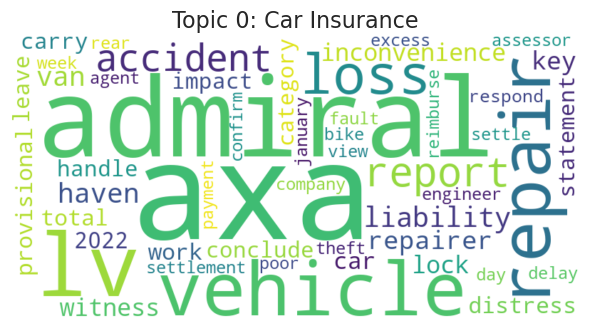

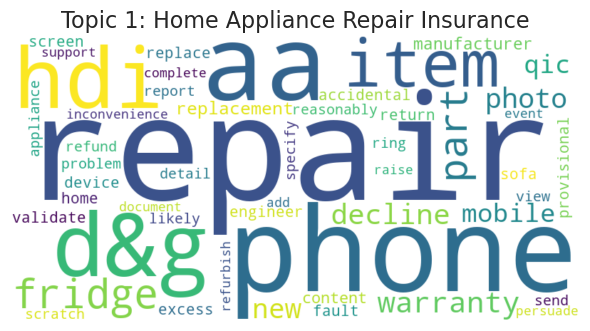

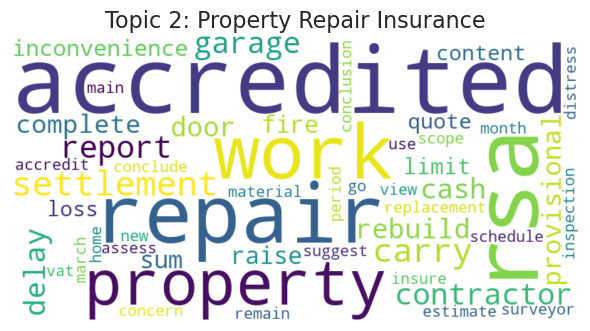

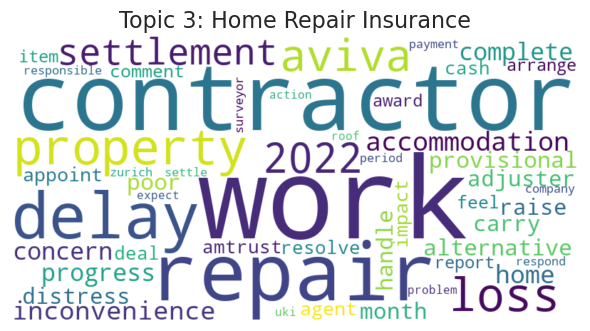

In [16]:
# create a dictionary to map the topic id to a description of the topic
# dict_topics = {
#     0: "Car Insurance (vehicle loss, repair, and accident liability)",
#     1: "Home Appliance Repair Insurance (appliance repairs, warranties, and claim denials)",
#     2: "Property Repair Insurance (certified repairs, home repairs, and property settlements)",
#     3: "Home Repair Insurance (work delays, property loss, and compensation)",
#     4: "Travel Insurance (vehicle delays and travel issues)",
#     5: "Car Insurance (driver and vehicle issues and claim denials)",
#     6: "Home Boiler Insurance (boiler repairs, replacements, and engineer services)",
#     7: "Legal Expense Insurance (legal consultations, disputes, and litigation costs)",
#     8: "Car Insurance (vehicle valuation and settlement)",
#     9: "Home Water Damage Insurance (water leaks, storm damage, and repairs)",
#     10: "Subsidence Insurance (property foundation issues and related compensation)",
#     11: "Insurance Fraud (misrepresentation and claim disputes)",
#     12: "Insurance Premiums and Renewals (premium increases and renewal issues)",
#     13: "Health Insurance (medical treatments, claim denials, and hospital issues)"
# }

# create a dictionary to map the topic id to a description of the topic
dict_topics = {
    0: "Car Insurance",
    1: "Home Appliance Repair Insurance",
    2: "Property Repair Insurance",
    3: "Home Repair Insurance",
    4: "Travel Insurance",
    5: "Car Insurance",
    6: "Home Boiler Insurance",
    7: "Legal Expense Insurance",
    8: "Car Insurance",
    9: "Home Water Damage Insurance",
    10: "Subsidence Insurance",
    11: "Insurance Fraud",
    12: "Insurance Premiums and Renewals",
    13: "Health Insurance"
}


# draw a word cloud for a topic
def draw_word_cloud(lda_model, topic_id, dict_topics=dict_topics):
    # get the words in the topic
    words = lda_model.show_topic(topic_id, topn=50)
    
    # create a dictionary from the words
    word_dict = {word: score for word, score in words}
    
    # create the word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    
    # plot the word cloud
    plt.figure(figsize=(6, 6))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}: {dict_topics[topic_id]}', fontsize=16)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.savefig(f'plots/topic-{topic_id}-word-cloud.png', dpi=300)
    plt.show()

# draw the word cloud for the topics
for topic_id in range(4):
    draw_word_cloud(lda_model, topic_id)


### Distribution of topics in the dataset

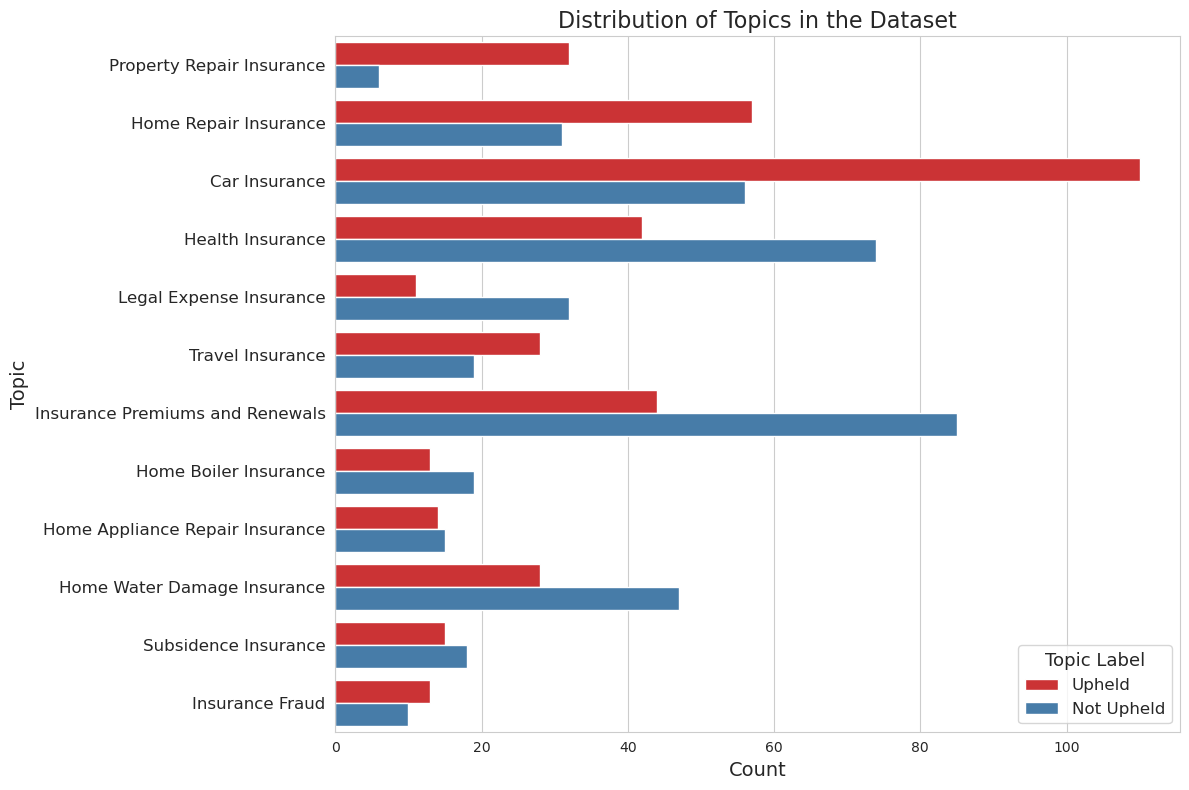

In [118]:
# assign topics to the documents
topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# create a dataframe with the topics
df_topics = pd.DataFrame({'topic': topics, 'topic_label': train_labels})

def plot_topic_distribution(df_topics, dict_topics):
    df_topics['topic_label'] = df_topics['topic_label'].map({1: 'Upheld', 0: 'Not Upheld'})
    df_topics['topic'] = df_topics['topic'].map(dict_topics)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    sns.countplot(y='topic', hue='topic_label', data=df_topics, palette='Set1')
    
    plt.title('Distribution of Topics in the Dataset', fontsize=16)
    plt.ylabel('Topic', fontsize=14)
    plt.xlabel('Count', fontsize=14)
    plt.legend(title='Topic Label', title_fontsize='13', fontsize='12', loc='lower right')
    plt.yticks(fontsize=12)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution.png', dpi=300)
    plt.show()


plot_topic_distribution(df_topics, dict_topics)

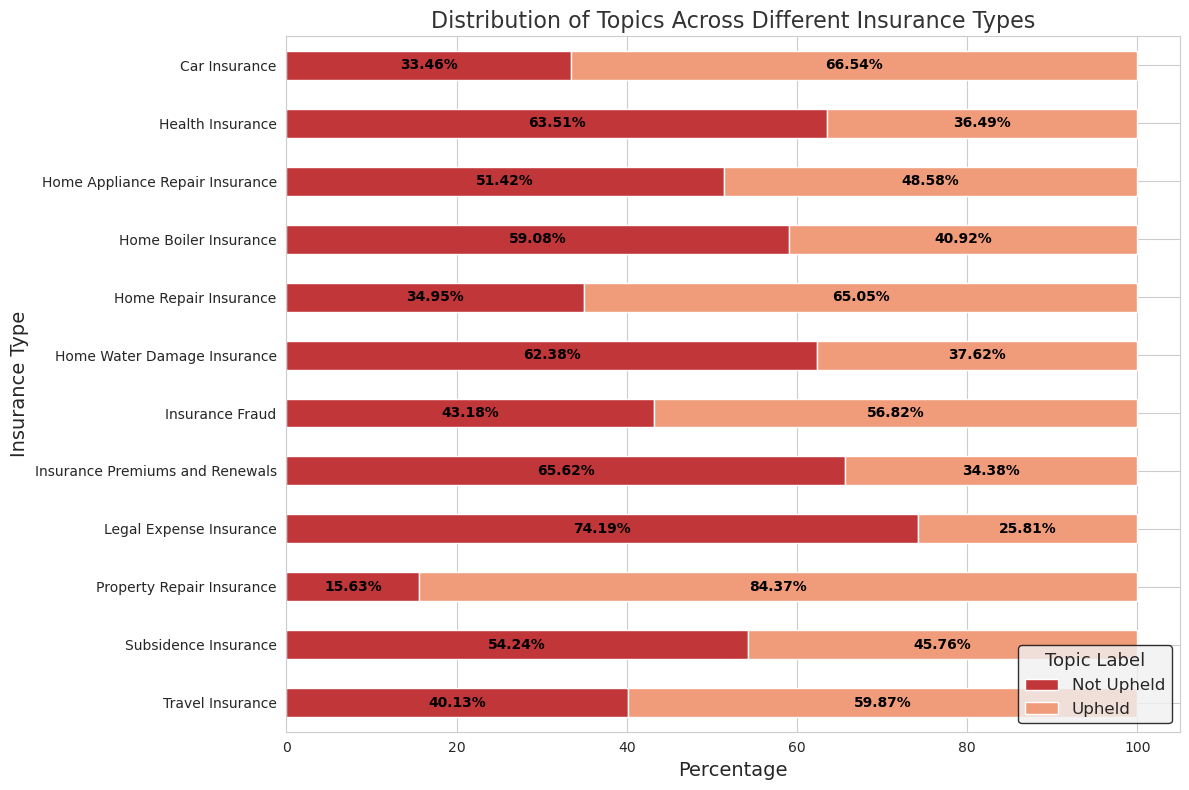

In [121]:
# calculate the topic distribution for each label (percentage)
topic_distribution = df_topics.groupby('topic_label')['topic'].value_counts(normalize=True).unstack()
# dive the topic distribution by the sum of the values in each column
topic_distribution = topic_distribution.div(topic_distribution.sum(axis=0), axis=1)
# multiply the values by 100 to get percentages
topic_distribution = topic_distribution * 100

def plot_distribution_percent(df):
    # define a professional and aesthetically pleasing color palette
    # set color palette (muted
    colors = sns.color_palette(palette='RdBu')
    # create a horizontal stacked bar plot
    ax = df.T.plot(kind='barh', stacked=True, figsize=(12, 8), color=colors, edgecolor='white', linewidth=1)

    # set titles and labels with enhanced font settings
    plt.title('Distribution of Topics Across Different Insurance Types', fontsize=16, color='#333333')
    plt.xlabel('Percentage', fontsize=14)
    plt.ylabel('Insurance Type', fontsize=14)

    # improve legend aesthetics
    legend = plt.legend(title='Topic Label', fontsize=12, title_fontsize='13', loc='lower right')
    frame = legend.get_frame()
    frame.set_color('#f0f0f0')
    frame.set_edgecolor('black')

    # annotate percentage values on the bars
    for p in ax.patches:
        width = p.get_width()
        label_text = f'{width:.2f}%'
        label_x_pos = p.get_x() + width / 2
        label_y_pos = p.get_y() + p.get_height() / 2
        ax.annotate(label_text, (label_x_pos, label_y_pos), ha='center',
                     va='center', fontsize=10, color='black', fontweight='bold')

    # reverse the y-axis to have the top values at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/topic-distribution-percent.png', dpi=300)
    
    # show plot
    plt.show()


plot_distribution_percent(topic_distribution)

In [14]:
# visualise the topics 
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.094376 -0.005289       1        1  12.499586
3     -0.080353  0.019481       2        1  12.265573
13     0.030505 -0.056575       3        1  11.386992
9     -0.153687 -0.006769       4        1  10.263046
8      0.120015  0.058855       5        1   9.151280
7     -0.016188 -0.069413       6        1   6.247246
0      0.028345  0.082925       7        1   5.902376
4      0.056957  0.121488       8        1   5.756312
5      0.116458  0.052464       9        1   5.453267
2     -0.098018  0.008461      10        1   5.293867
6     -0.045874  0.074183      11        1   4.495268
10    -0.114553 -0.098950      12        1   4.425239
1     -0.051782  0.044317      13        1   3.503860
11     0.113798 -0.225178      14        1   3.356088, topic_info=           Term         Freq        Total Category  logprob  loglift
1582        axa  1416.000000  1416.000000  Default  30.0000  30.0000
628         car  2670.000000  2670.000000  Default  29.0000  29.0000
1323      aviva  2026.000000  2026.000000  Default  28.0000  28.0000
1381      esure   950.000000   950.000000  Default  27.0000  27.0000
1449  advantage   935.000000   935.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
706     vehicle    75.206449  1286.410449  Topic14  -4.9539   0.5550
622       apply    65.310656   709.017005  Topic14  -5.0950   1.0097
1206   business    63.730083   631.718334  Topic14  -5.1195   1.1006
552     premium    60.995540  1330.568770  Topic14  -5.1634   0.3118
819     decline    52.302568  1553.765024  Topic14  -5.3171   0.0030

[890 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1395      1  0.159443      00
1395      2  0.003392      00
1395      5  0.624204      00
1395      7  0.094988      00
1395      8  0.088203      00
...     ...       ...     ...
2348      2  0.267138  zurich
2348      4  0.001746  zurich
2348      5  0.001746  zurich
2348      8  0.726336  zurich
2348     10  0.001746  zurich

[4187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 14, 10, 9, 8, 1, 5, 6, 3, 7, 11, 2, 12])